<a href="https://colab.research.google.com/github/alif-munim/deep-learning/blob/master/imagen_flickr8k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
  # ! pip install --upgrade imagen-pytorch

In [1]:
! pip install --upgrade imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
# ! pip install numba

In [2]:
import torch
import torchvision

In [3]:
import imageio.v3 as iio
import numpy as np 
import os
import torch
import cv2

In [4]:
import os

f = []
images = []

for (dirpath, dirnames, filenames) in os.walk('/content/flickr8k/images'):
    f.extend(filenames)
    break

for filename in f:
    images.append(filename)
    
images = sorted(images)

In [5]:
import pandas

captions = pandas.read_csv("/content/flickr8k/captions.txt")
captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [6]:
len(images)

683

In [7]:
(captions.loc[captions['image'] == '2315807231_6948b3f3a5.jpg'].iloc[0]['caption'])

'A brown dog is shaking off the snow .'

In [8]:
count = 0
img_tensors = []
img_captions = []

for img in images:
    im_path = '/content/flickr8k/images/' + str(img) 

    im = iio.imread(im_path, index=None)
    im = cv2.resize(im, (64,64))
    img_arr = np.asarray(im)

    # print(img_arr.shape)
    # img_arr = np.moveaxis(img_arr, -1, 1)
    img_tensor = torch.from_numpy(img_arr)
    img_tensor = img_tensor.type(torch.float32)
    img_tensor = img_tensor.to(device="cuda")

    img_caption = (captions.loc[captions['image'] == str(img)].iloc[0]['caption'])

    # print(img_tensor.shape)

    # img_desc = [lines[count]]
    # count += 1

    img_tensors.append(img_tensor)
    img_captions.append(img_caption)

A brown dog is shaking his head while standing on sand .


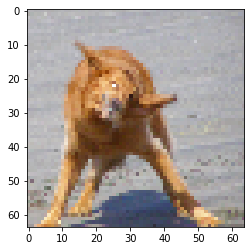

In [9]:
from matplotlib.pyplot import imshow

sample_idx = 72

x = img_tensors[sample_idx].cpu().detach().numpy()
# x = np.moveaxis(x, 0, -1)
x = x.astype(np.uint8)

imshow(x)
print(img_captions[sample_idx])

In [10]:
img_batches = []

for i in range(0, len(img_tensors), 2):

  if len(img_tensors) - (i + 2) > 0:
    a = img_tensors[i]
    b = img_tensors[i+1]
    # c = img_tensors[i+2]
    # d = img_tensors[i+3]

    z = torch.stack((a,b), dim=0)
    img_batches.append(z)

In [11]:
caption_batches = []
batch_size = 2

for i in range(0, len(img_captions), batch_size):

  if len(img_captions) - (i + batch_size) > 0:
    a = img_captions[i]
    b = img_captions[i+1]
    # c = img_captions[i + 2]
    # d = img_captions[i + 3]

    z = [a,b]

    caption_batches.append(z)

In [12]:
img_batches[0].shape

torch.Size([2, 64, 64, 3])

In [13]:
caption_batches[0]

['A man sitting cross-legged in a field',
 'An african american woman wearing an orange dress with a hood is covering her face with her hand while sitting in a chair .']

In [14]:
from imagen_pytorch import t5

embed_batches = []

for i in range(len(caption_batches)):
  # encoded_input = tokenizer(desc_batches[i], padding=True, return_tensors='pt')
  encoded_input = t5.t5_encode_text(caption_batches[i], name='t5-large')
  embed_batches.append(encoded_input)

In [15]:
import torch
from imagen_pytorch import Unet, Imagen, ImagenTrainer

# unet for imagen

unet1 = Unet(
    dim = 64, # The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/
    cond_dim = 512,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = 3,
    layer_attns = (False, True, True, True),
)

imagen = Imagen(
    unets = (unet1),
    text_encoder_name = 't5-large',
    image_sizes = (64),
    timesteps = 1000,
    cond_drop_prob = 0.1
).cuda()

The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/


In [16]:
trainer = ImagenTrainer(imagen)

In [17]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

save_path = '/content/gdrive/My Drive/Research'
trainer.save(os.path.join(save_path, 'imagen_sample.ckpt'))

Mounted at /content/gdrive
checkpoint saved to /content/gdrive/My Drive/Research/imagen_sample.ckpt


In [ ]:
trainer.load(os.path.join(save_path, 'imagen_sample.ckpt'))

In [19]:
images = imagen.sample(
    texts = caption_batches[0], cond_scale = 3)

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

A man sitting cross-legged in a field


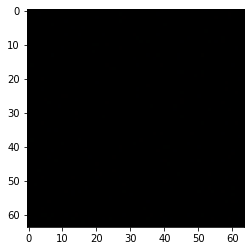

In [29]:
# Visualize a single image (sampled from untrained imagen model)

x = images[0].cpu().detach().numpy()
x = np.moveaxis(x, 0, -1)
x = x.astype(np.uint8)

imshow(x)
print(caption_batches[0][0])

In [ ]:
print(f'Checkpoints will be saved at {save_path}')

# checkpoint = None

current_epoch = 25
checkpoint = 'imagen_1unet_text2image_epoch' + str(current_epoch) + '.ckpt'

num_epochs = 50

if checkpoint: 
  trainer.load(os.path.join(save_path, checkpoint))
else:
  current_epoch = 0

for epoch in range(num_epochs):

  print(f'Beginning epoch {current_epoch + epoch + 1}...')

  for i in range(len(img_batches)):
    image_batch = img_batches[i]
    image_batch = image_batch.moveaxis(-1, 1)
    image_batch = image_batch.to(device="cuda")
    # embed_batch = embed_batches[i]['input_ids']
    embed_batch = embed_batches[i]
    # text_batch = text_batch.cuda()

    loss = trainer(
      image_batch,
      text_embeds = embed_batch,
      unet_number = 1,            # training on unet number 1 in this example, but you will have to also save checkpoints and then reload and continue training on unet number 2
      max_batch_size = 4          # auto divide the batch of 64 up into batch size of 4 and accumulate gradients, so it all fits in memory
    )

    trainer.update(unet_number = 1)

    if i % 5 == 0 or i == (len(img_batches) - 1):
      print(f'Image batches processed: {i}/{len(img_batches)}')

  if ((current_epoch + epoch + 1) % 5) == 0:
    ckpt_name = 'imagen_1unet_text2image_epoch' + str(current_epoch + epoch + 1) + '.ckpt'

    trainer.save(os.path.join(save_path, ckpt_name))
    print(f'Saved checkpoint for epoch {current_epoch + epoch + 1}')
  
  print(f'\n\n')

In [ ]:
# trainer.load(os.path.join(save_path, 'imagen_1unet_text2image_epoch75.ckpt'))

In [38]:
# Be sure to sample the trainer, not imagen

images = trainer.sample(
    texts = caption_batches[0], cond_scale = 3)

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

A man sitting cross-legged in a field


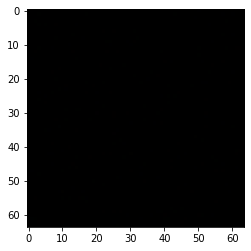

In [39]:
# Visualize a single image (sampled from untrained imagen model)
# After 25 epochs (341 batches, 2 images each)
batch_idx = 0

x = images[batch_idx].cpu().detach().numpy()
x = np.moveaxis(x, 0, -1)
x = x.astype(np.uint8)

imshow(x)
print(caption_batches[0][batch_idx])

A man sitting cross-legged in a field


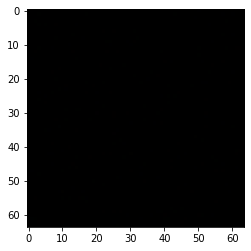

In [42]:
# Visualize a single image (sampled from untrained imagen model)
# After 75 epochs (341 batches, 2 images each)

batch_idx = 0

x = images[batch_idx].cpu().detach().numpy()
x = np.moveaxis(x, 0, -1)
x = x.astype(np.uint8)

imshow(x)
print(caption_batches[0][batch_idx])

In [ ]:
import gc
from numba import cuda 

trainer = None
imagen = None
gc.collect()

with torch.no_grad():
    torch.cuda.empty_cache()

device = cuda.get_current_device()
device.reset()

In [ ]:
! nvidia-smi

Tue Feb  7 20:42:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    27W /  70W |   2790MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Misc

In [ ]:
# flowers_data = torchvision.datasets.Flowers102('flowers_102/', download=True)
# data_loader = torch.utils.data.DataLoader(flowers_data,
#                                           batch_size=4,
#                                           shuffle=True,
#                                           num_workers=4)

In [ ]:
# flickr_data = torchvision.datasets.Flickr8k('flickr_8k/', 'flickr_8k/annotations.tst', download=True)
# data_loader = torch.utils.data.DataLoader(flickr_data,
#                                           batch_size=4,
#                                           shuffle=True,
#                                           num_workers=4)

In [ ]:
# import scipy
# mat = scipy.io.loadmat('flowers_102/flowers-102/imagelabels.mat')

In [ ]:
# mat

In [ ]:
# len(mat['labels'][0])

In [ ]:
# mat['labels'][0]

In [ ]:
# ! unzip dataset.zip

In [ ]:
images[0:10]


['763577068_4b96ed768b.jpg',
 '765091078_a8a11c6f9e.jpg',
 '765298136_7805fbb079.jpg',
 '765929807_de381cc764.jpg',
 '766061382_6c7ff514c4.jpg',
 '766099402_cdda6964f0.jpg',
 '766346887_a9a9d0637a.jpg',
 '769260947_02bc973d76.jpg',
 '771048251_602e5e8f45.jpg',
 '771366843_a66304161b.jpg']

In [ ]:
len(images)

186